In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools

In [2]:
df = pd.read_csv('../data/clean_train.csv')

In [3]:
#some datetime manipulations
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [4]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

Text(0.5, 1.0, 'Number of Rides over the Year')

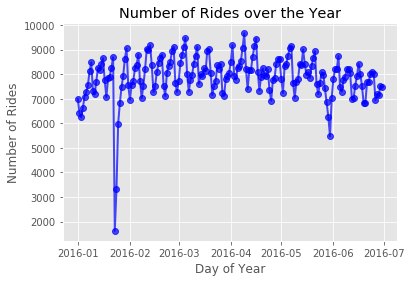

In [5]:
#plotting number of rides over the course of January to June

plt.plot(df.groupby('date').count()['id'], 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Year')

# Seasonal Adjustment with Differencing

Our time series contains weekly seasonal variation, which are cycles that repeat regularly over time. 

In [6]:
count =  df.groupby('date').count()['id']
series = pd.DataFrame(({'day': count.index, 'count': count.values})).set_index('day')
series.head()

,count
day,
2016-01-01,6993
2016-01-02,6415
2016-01-03,6238
2016-01-04,6620
2016-01-05,7088


Since the weekly seasonality of our time series has been identified, it can be modeled.<br>
The model of seasonality can be removed from the time series. This process is called seasonal adjustment. <br>
A time series were the seasonal component has been removed is called seasonal stationary.<br>    

In the plot below, we consider that every month, there is a seasonal trend that repeats itself. We will take out the first month of values (becuase there is no prior month before that) and subtract the following values by the value of the number of rides of the day that came 30 days prior to it. 

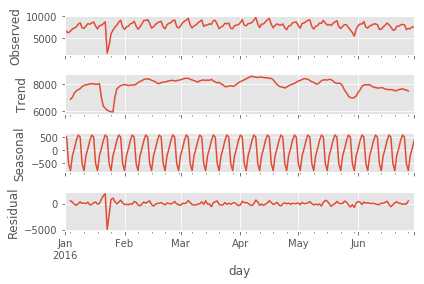

In [7]:
## ETS Graph (Error Trend Seasonality)

from statsmodels.tsa.seasonal import seasonal_decompose

result_ets = seasonal_decompose(series['count'],model='add')
result_ets.plot();

The Error-Trend-Seasonality graph above shows information regarding the following components:

- Observed time series
- Trend: Reflects long term progression of series
- Seasonality: Reflects seasonal variation and checks if seasonal pattern exists in the time series
- Residual: Shows irregular component (or "noise") at time t, which describes random, irregular influences

While the trend is hard to pin down (especially because of the one anomalous dip in count) we can see that there is a strong weekly seasonal component in the time sries shown above. The residuals also show us that the dip in count on Jan. 23rd should be considered as an anomaly.


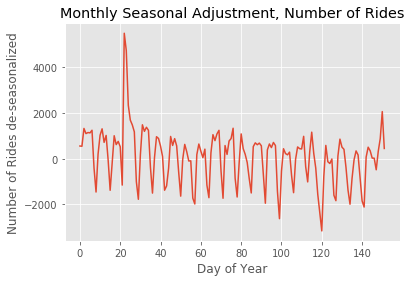

In [8]:
#Differncing by week for seasonal adjustment

X = series.values
diff = list()
days_in_month =30
for i in range(days_in_month, len(X)):
    value = X[i] - X[i - days_in_month]
    diff.append(value)
plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides de-seasonalized')
plt.title('Monthly Seasonal Adjustment, Number of Rides')
plt.show()

We can also consider the number fo rides within any given period of the year is probably stable. We can take this idea and consider all number of rides within a week to be stable. We can then subtract the average weekly number of rides from the previous week. 

Resample the dataset to a weekly average:

                  count
day                    
2016-01-03  6548.666667
2016-01-10  7493.000000
2016-01-17  8017.142857
2016-01-24  6385.428571
2016-01-31  7633.571429
2016-02-07  7912.000000
2016-02-14  8328.142857
2016-02-21  8045.000000
2016-02-28  8242.714286
2016-03-06  8399.571429
2016-03-13  8133.714286
2016-03-20  8333.142857
2016-03-27  7805.142857


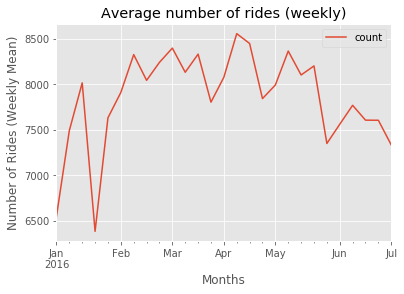

In [9]:
resample = series.resample('W')
weekly_mean = resample.mean()
print(weekly_mean.head(13))
weekly_mean.plot()
plt.xlabel('Months')
plt.ylabel('Number of Rides (Weekly Mean)')
plt.title('Average number of rides (weekly)')
plt.show()

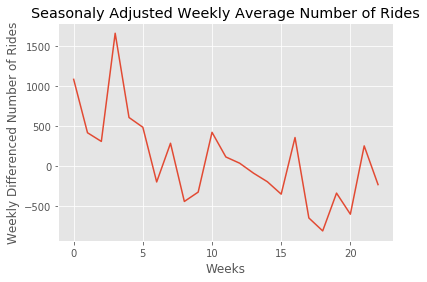

In [10]:
resample = series.resample('W')
weekly_mean = resample.mean()

diff = list()
weeks_in_month = 4
for i in range(weeks_in_month , len(weekly_mean)):
    value = weekly_mean.values[i] - weekly_mean.values[i - weeks_in_month]
    diff.append(value)
plt.plot(diff)
plt.xlabel('Weeks')
plt.ylabel('Weekly Differenced Number of Rides')
plt.title('Seasonaly Adjusted Weekly Average Number of Rides')
plt.show()

The above plot shows a new seasonaly adjusted weekly average number of rides, skipping the first four weeks of data in order to create the adjustment (We subtract the weekly mean value of our adjustment by the weekly mean value of the data 4 weeks prior)

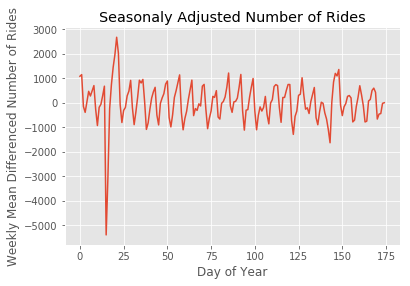

In [11]:
X = series.values
diff = list()
days_in_week = 7

for i in range(days_in_week, len(X)):
    date_ind = series.index[i].dayofyear
    last_week_mean = series.iloc[date_ind - 7 : date_ind].mean()
    value = X[i] - last_week_mean
    diff.append(value)

plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Weekly Mean Differenced Number of Rides')
plt.title('Seasonaly Adjusted Number of Rides')
plt.show()

We can use the weekly average number of rides data to make this adjustment to the daily vlaues. The first week of values has been skipped (since they dont have a previous week of values to average and subtract by), and the rest of the values were subtracted by the average values of the number of rides of the 7 days prior to that day. This type of differencing makes the dataset more robust to daily fluctuations. It can be improved upon by using other metrics, such as previous month's mean, etc. 

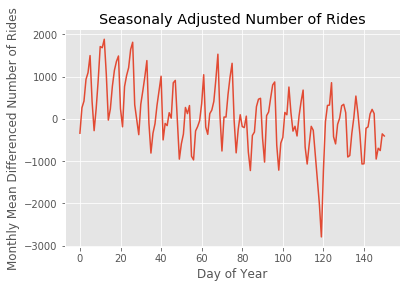

In [12]:
X = series.values
diff = list()
days_in_year = 31
for i in range(days_in_year, len(X)):
    month_str = str(series.index[i].year)+'-'+str(series.index[i].month- 1)
    month_mean_last_month = series[month_str].mean()
    value = X[i] - month_mean_last_month
    diff.append(value)
plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Monthly Mean Differenced Number of Rides')
plt.title('Seasonaly Adjusted Number of Rides')
plt.show()

Here, we skipped the first month of data, averaged the previous month of number of rides, and then subtracted the value from the following days' number of rides. 

# Seasonal Adjustment with Modeling

We can model the seasonal component directly as a sine wave over a generally fixed period and amplitude. We can choose a single week/month of data, or all of the data. We could also smooth the observations using a moving average centered on each value. 

When using np.polyfit(), a consistent sine wave can usually be modeled by using order 4 or 5.

In [13]:
count1 =  df.groupby('date').count()['id']
series1 = pd.DataFrame(({'day': count1.index, 'count': count1.values}))
series1.head()

,day,count
0,2016-01-01,6993
1,2016-01-02,6415
2,2016-01-03,6238
3,2016-01-04,6620
4,2016-01-05,7088


In [14]:
series1.index.shape

(182,)

In [15]:
x_new =  series1.index.copy()

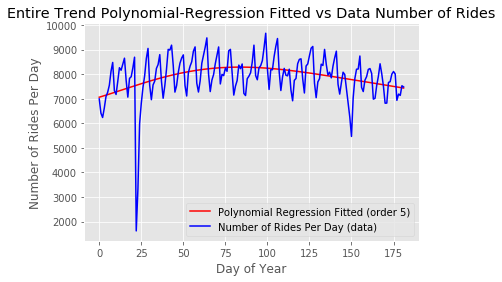

In [16]:
import numpy.polynomial.polynomial as poly
coefs = poly.polyfit(series1.index, series1['count'], 5)
ffit = poly.polyval(x_new, coefs)
plt.plot(x_new, ffit, color= 'red', label = 'Polynomial Regression Fitted (order 5)')
plt.plot(series.values, color= 'blue' , label = 'Number of Rides Per Day (data)')
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides Per Day')
plt.title('Entire Trend Polynomial-Regression Fitted vs Data Number of Rides')
plt.legend()
plt.show()


np.polyfit cannot fit the regression line properly at the bigger scale, let's look at a week of increments, using the average values.

In [17]:
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

In [18]:
print('Tootal weeks in the duration of the time series : %i' %(len(series)/7))

Tootal weeks in the duration of the time series : 26


In [19]:
count2 =  df.groupby('dayofweek').count()['id']
series2 = pd.DataFrame(({'day': count2.index, 'count': count2.values / 26}))
series2.head()

,day,count
0,0,7103.846154
1,1,7687.115385
2,2,7968.769231
3,3,8280.192308
4,4,8468.269231


In [20]:
x_new1 =  series2.index.copy()

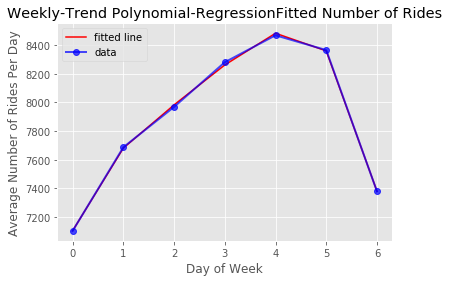

In [21]:
coefs = poly.polyfit(series2.index, series2['count'], 5)
ffit = poly.polyval(x_new1, coefs)
plt.plot(x_new1, ffit, color= 'red', label = 'fitted line')
plt.plot(df.groupby('dayofweek').count()['id'].index, (df.groupby('dayofweek').count()['id'].values / 26) , 'bo-', lw=2, alpha=0.7, label = 'data')
plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-RegressionFitted Number of Rides')
plt.show()
plt.show()

In [22]:
#ffit = poly.Polynomial(coefs)    # instead of np.poly1d
#plt.plot(x_new1, ffit(x_new1))

Create a dataframe of the indexed day of weeks and the fitted average count values

In [23]:
deseason = pd.DataFrame(({'dayofweek': x_new1 , 'fitted_count': ffit}))
deseason.head(7)


,dayofweek,fitted_count
0,0,7104.795871
1,1,7681.417083
2,2,7983.014985
3,3,8261.197969
4,4,8482.514985
5,5,8359.301698
6,6,7380.526640


In [24]:
count1 =  df.groupby('date').count()['id']
final = pd.DataFrame(({'day': count1.index, 'count': count1.values}))

Create a day of week column for a dataset that contains the entire data from January to June

In [25]:
final['dayofweek'] = final['day'].dt.dayofweek

In [26]:
final.head(10)

,day,count,dayofweek
0,2016-01-01,6993,4
1,2016-01-02,6415,5
2,2016-01-03,6238,6
3,2016-01-04,6620,0
4,2016-01-05,7088,1
5,2016-01-06,7262,2
6,2016-01-07,7550,3
7,2016-01-08,8117,4
8,2016-01-09,8479,5
9,2016-01-10,7335,6


Merge such that the final dataframe will contain both the actual count values for each day, and the corresponding fitted polynomial values for the day of week value resides in

In [27]:
final_df = pd.merge(final,
                    deseason[['dayofweek', 'fitted_count']],
                    left_on = 'dayofweek',
                    right_on = 'dayofweek',
                    how = 'left')


In [28]:
final_df['final_count'] = (round(final_df['count'] - final_df['fitted_count']))

In [29]:
final_df.head(10)

,day,count,dayofweek,fitted_count,final_count
0,2016-01-01,6993,4,8482.514985,-1490.0
1,2016-01-02,6415,5,8359.301698,-1944.0
2,2016-01-03,6238,6,7380.526640,-1143.0
3,2016-01-04,6620,0,7104.795871,-485.0
4,2016-01-05,7088,1,7681.417083,-593.0
5,2016-01-06,7262,2,7983.014985,-721.0
6,2016-01-07,7550,3,8261.197969,-711.0
7,2016-01-08,8117,4,8482.514985,-366.0
8,2016-01-09,8479,5,8359.301698,120.0
9,2016-01-10,7335,6,7380.526640,-46.0


Plot the resulting weekly trend polynomial-regression subtracted deseasonalized data.

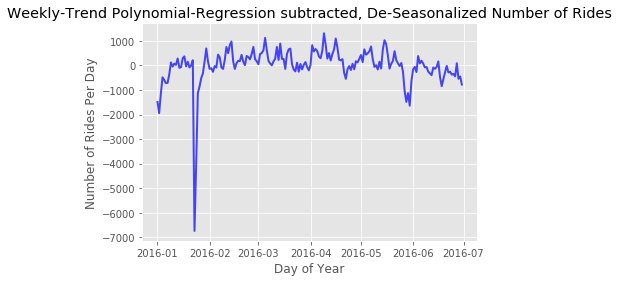

In [30]:
plt.plot(final_df.day, final_df.final_count , 'b-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-Regression subtracted, De-Seasonalized Number of Rides')
plt.show()

Get rid of January data, to see if De-Seasaonalizing by weekly trends worked.

In [53]:
clean_df =  final_df[31:]


In [54]:
clean_df.columns

Index(['day', 'count', 'dayofweek', 'fitted_count', 'final_count'], dtype='object')

In [55]:
df2 = clean_df[['day', 'final_count']]

In [56]:
df2.set_index('day', inplace = True)
df2.index = pd.RangeIndex(len(df2.index))
df2.head()

,final_count
0,-143.0
1,-117.0
2,-262.0
3,-26.0
4,-89.0


In [57]:
from statsmodels.tsa.stattools import adfuller

useful_values_raw = adfuller(df2['final_count'], autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

,Value,Label
0,-5.444991,Test Statistic
1,0.000030,p-value
2,0.000000,#Lags Used
3,150.000000,Number of Observations Used
4,-4.020427,Critical value for 1%
5,-3.440174,Critical value for 5%
6,-3.144468,Critical value for 10%


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Rejecting that there is a unit root -> time series is stationary

Since the pvalue is extremely close to 0, we can reject the null hypothesis and assume that the weekly seasonality transformation of the time series has detrended the data significantly enough that it can be considered as stationary.

In [58]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

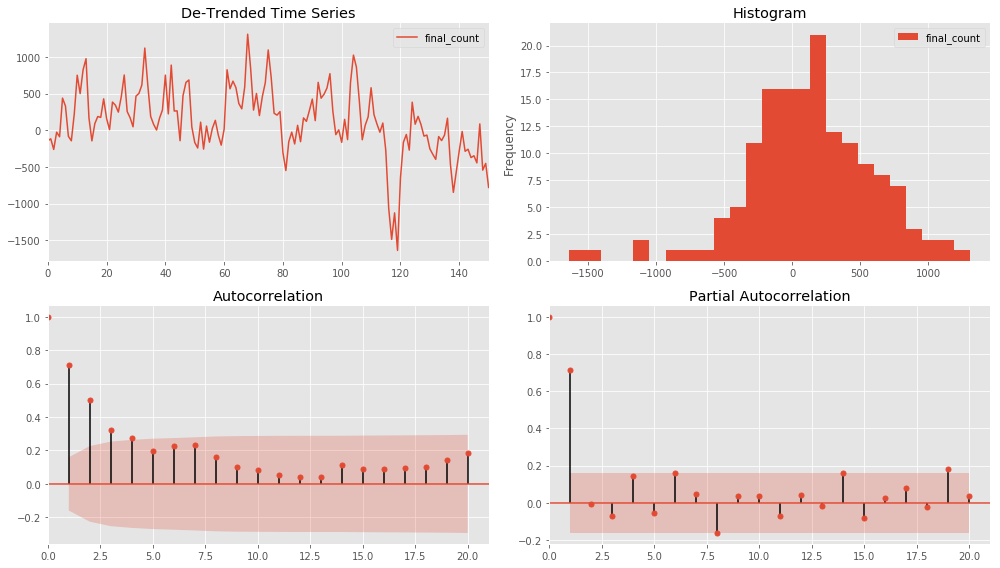

In [59]:
tsplot(df2, title='De-Trended Time Series', lags=20);

**ARIMA model determination**

The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |

Looking at the subplots above, it may be wise to use the AR models since it best describes our time series behavior. This is all theoretical however, and the best model may also not end up being an autoregressive model.

# Seasonal ARIMA Modelling

We can use the statsmodel's SARIMAX function to model a seasonal arima model on our dataset by prescribing a set of p,d,q variables. Calling the summary method on the fitted model then gives information about the fitted model including information criterion such as AIC and BIC.

We will also take the first 90% of the dataset as our prediction values, and leave out the most recent 10% of the dataset as the prediction (test) values. We dont want to take a random split of training and test datas because in this time series, we want to see how well we can predict our out of sample "future" values for ride demand. 

In [60]:
n_sample = df2.shape[0]
print('New length of the entire dataset is : %i' %n_sample)

New length of the entire dataset is : 151


In [75]:
n_train=int(0.90*n_sample) + 1
n_forecast=n_sample-n_train

ts_train = df2.iloc[:n_train]['final_count']
ts_test = df2.iloc[n_train:]['final_count']

In [76]:
print(('Number of in sample training dataset : %i' %len(ts_train)))
print(('Number of out of sample testing dataset : %i' %len(ts_test)))

Number of in sample training dataset : 136
Number of out of sample testing dataset : 15


Including seasonal_order with the AR and MA component and period of 7 days (weekly). 
Simple differencing is set to true such that we can forecast and calculate the error values later on the held out "future" data


In [77]:
arima111 = sm.tsa.statespace.SARIMAX(ts_train, order=(1,0,1), seasonal_order= (1,0,1,7), simple_differencing=True)
model_results = arima111.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                       final_count   No. Observations:                  136
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -969.518
Date:                           Sun, 14 Jul 2019   AIC                           1949.035
Time:                                   15:27:56   BIC                           1963.599
Sample:                                        0   HQIC                          1954.953
                                           - 136                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7255      0.061     11.803      0.000       0.605       0.846
ma.L1          0.0261      0.099      0.264      0.792      -0.167       0.219
ar.S.L7        0.9659      0.048     20.285      0.000       0.873       1.059
ma.S.L7       -0.8614      0.119     -7.220      0.000      -1.095      -0.628
sigma2      8.831e+04   1.03e+04      8.614      0.000    6.82e+04    1.08e+05
===================================================================================
Ljung-Box (Q):                       31.08   Jarque-Bera (JB):                 7.36
Prob(Q):                              0.84   Prob(JB):                         0.03
Heteroskedasticity (H):               1.56   Skew:                            -0.30
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The following function will gather the BIC metric given a set of p,d,q values to try out.

In [78]:
#credit to Jeffery Yau @ https://www.youtube.com/watch?v=tJ-O3hk1vRwhttps://www.youtube.com/watch?v=tJ-O3hk1vRw
#PyData SF2016 conference

import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

C:\Users\Justin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Justin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Justin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Justin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


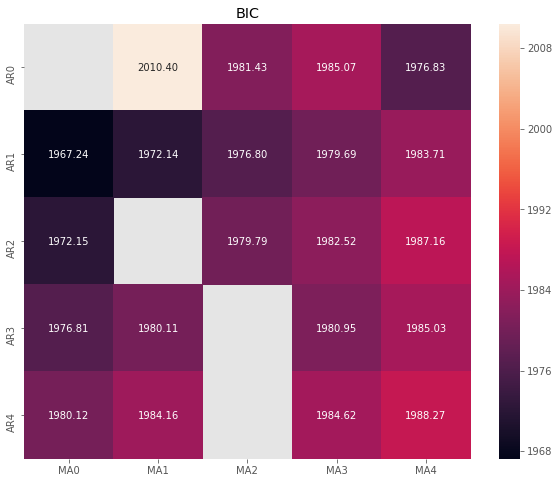

In [79]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

Plotting the above function as a heatmap, we can see that AR 1 and MA 0 gives us the lowest BIC measure out of all of the different combinations of input variables.

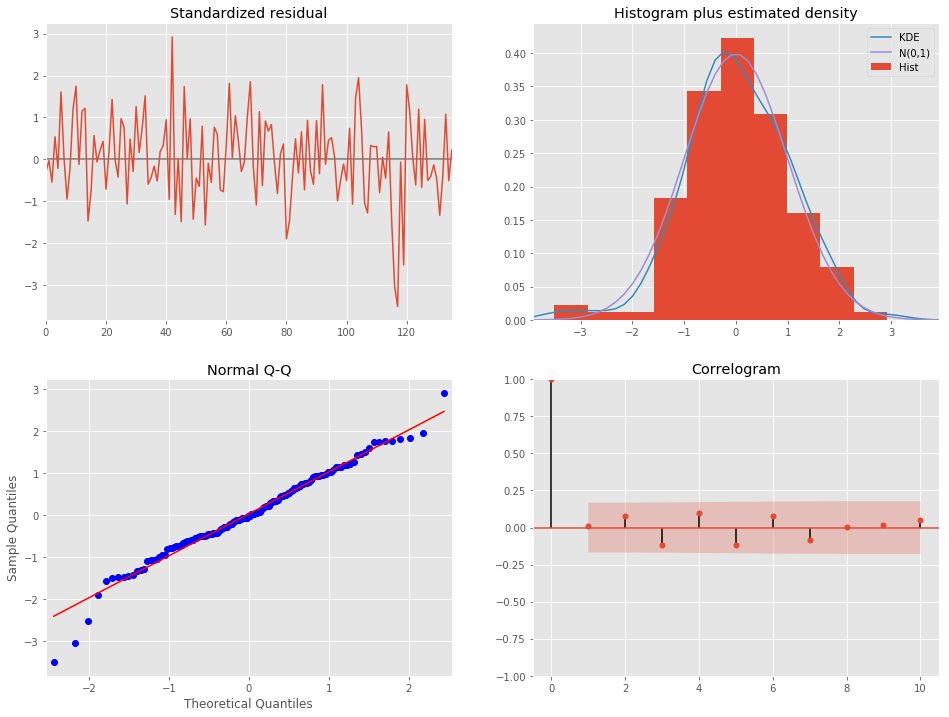

In [80]:
model_results.plot_diagnostics(figsize=(16, 12));

Finally, using the plot_diagnostic method on the model defined with AR 1 and MA 1 order components, we can see featuers such as residuals, histogram, normality, and correlogram. 

For the most part, from looking at the plot distributions of the residuals from the SARIMAX model, we can see that the residuals look scattered around zero, and are roughly normally distributed when looking at the histogram and the linear fit. The correlation values mostly stay within the 95% confidence range as well. 

By taking out the first 25 days of values, we have effectively made our dataset more normally pleasant. 

In [81]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test heteroskedasticity of residuals (breakvar): stat=1.561, p=0.139

Test normality of residuals (jarquebera): stat=7.359, p=0.025

Test serial correlation of residuals (ljungbox): stat=31.081, p=0.843

Durbin-Watson test on residuals: d=1.98
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


Judging by the results of the statistics tests carried out above, we can conclude the following:

- The null hypothesis is of no heteroskedasticity is not rejected. 
- The test for normality of standardized residuals is not rejected. ($\alpha = 0.01$)
- The Jung-box test for no serial correlation of standardized residuals is not rejected 
- The Durbin-Watson test also shows no serial correlation as the value is near 2
- Both the AR and MA roots are outside of the unit circle, suggesting that our model has achieved invertibility

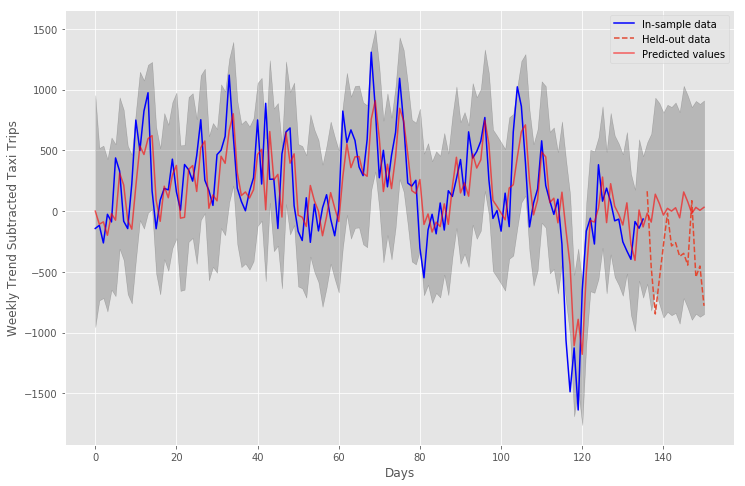

In [82]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, color = 'blue', label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin,
                                    end=pred_end)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.xlabel('Days')
plt.ylabel('Weekly Trend Subtracted Taxi Trips')
ax1.legend(loc='best');

In [83]:
def get_rmse(y, y_hat):

    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

In [89]:
rmse1 = get_rmse(ts_train, pred_mean.iloc[ts_train.index])
print("In sample RMSE: %.4f" % rmse1)

rmse2 = get_rmse(ts_test, pred_mean.iloc[-15:])
print("Out of Sample forecast RMSE: %.4f" % rmse2)


In sample RMSE: 300.2787
Out of Sample forecast RMSE: 490.0751


With our SARIMAX model, we achieve an in sample RMSE error value of 300, while we achieve an out of sample forecast RMLSE of 490. While our forecast model was only 15 data samples, we get a promising error metric, when considering that there are more than 7 thousand trips on average given any day in NYC.

Now, let's merge back into our original dataframe, so that we can reapply the weekly trends, and get the final transformed predictions on top of the original time series data.

In [85]:
pred_df = pd.DataFrame({'pred_count': pred_mean})

In [86]:
clean_df.index = pd.RangeIndex(len(clean_df.index))
clean_df.head()

,day,count,dayofweek,fitted_count,final_count
0,2016-02-01,6962,0,7104.795871,-143.0
1,2016-02-02,7564,1,7681.417083,-117.0
2,2016-02-03,7721,2,7983.014985,-262.0
3,2016-02-04,8235,3,8261.197969,-26.0
4,2016-02-05,8394,4,8482.514985,-89.0


In [87]:
result_df = clean_df.join(pred_df, how ='outer')
result_df['pred_fit'] = result_df['fitted_count'] + result_df['pred_count']
result_df.head()

,day,count,dayofweek,fitted_count,final_count,pred_count,pred_fit
0,2016-02-01,6962,0,7104.795871,-143.0,0.000000,7104.795871
1,2016-02-02,7564,1,7681.417083,-117.0,-107.754777,7573.662306
2,2016-02-03,7721,2,7983.014985,-262.0,-88.408697,7894.606288
3,2016-02-04,8235,3,8261.197969,-26.0,-198.857530,8062.340439
4,2016-02-05,8394,4,8482.514985,-89.0,-20.730590,8461.784395


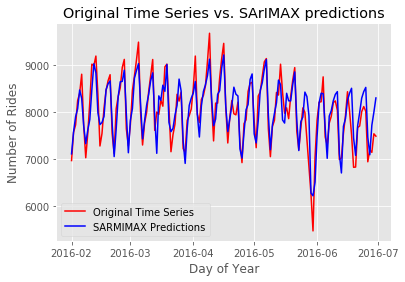

In [90]:
plt.plot(result_df['day'], result_df['count'], color = 'red', label = 'Original Time Series')
plt.plot(result_df['day'], result_df['pred_fit'], color = 'blue', label = 'SARMIMAX Predictions')
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Original Time Series vs. SArIMAX predictions')
plt.legend()
plt.show()

Finally, by looking at the above chart, we can see that the RMSE error of around 300 cars per day was not a bad measure at all. Our SARMIX model was able to fairly accurately predict the model and its weekly seasonality. 